In [1]:
# HIDDEN
from datascience import *
%matplotlib inline
path_data = '../../../data/'
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np

In [2]:
# HIDDEN

def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) - a * np.mean(table.column(x))

def fit(table, x, y):
    """Return the height of the regression line at each x value."""
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

### Least Squares Regression ###
In an earlier section, we developed formulas for the slope and intercept of the regression line through a *football shaped* scatter diagram. It turns out that the slope and intercept of the least squares line have the same formulas as those we developed, *regardless of the shape of the scatter plot*.

We saw this in the example about Little Women, but let's confirm it in an example where the scatter plot clearly isn't football shaped. For the data, we are once again indebted to the rich [data archive of Prof. Larry Winner](http://www.stat.ufl.edu/~winner/datasets.html) of the University of Florida. A [2013 study](http://digitalcommons.wku.edu/ijes/vol6/iss2/10/) in the International Journal of Exercise Science studied collegiate shot put athletes and examined the relation between strength and shot put distance. The population consists of 28 female collegiate athletes. Strength was measured by the the biggest amount (in kilograms) that the athlete lifted in the "1RM power clean" in the pre-season. The distance (in meters) was the athlete's personal best.

In [5]:
shotput = Table.read_table('https://umass-data-science.github.io/190fwebsite/notebooks/shotput.csv')

In [6]:
shotput

Weight Lifted,Shot Put Distance
37.5,6.4
51.5,10.2
61.3,12.4
61.3,13
63.6,13.2
66.1,13
70,12.7
92.7,13.9
90.5,15.5
90.5,15.8


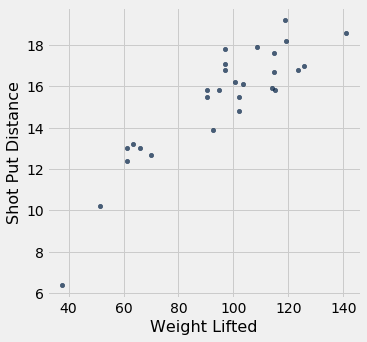

In [7]:
shotput.scatter('Weight Lifted')

That's not a football shaped scatter plot. In fact, it seems to have a slight non-linear component. But if we insist on using a straight line to make our predictions, there is still one best straight line among all straight lines.

Our formulas for the slope and intercept of the regression line, derived for football shaped scatter plots, give the following values.

In [8]:
slope(shotput, 'Weight Lifted', 'Shot Put Distance')

0.09834382159781997

In [9]:
intercept(shotput, 'Weight Lifted', 'Shot Put Distance')

5.959629098373952

Does it still make sense to use these formulas even though the scatter plot isn't football shaped? We can answer this by finding the slope and intercept of the line that minimizes the mse.

We will define the function `shotput_linear_mse` to take an arbirtary slope and intercept as arguments and return the corresponding mse. Then `minimize` applied to `shotput_linear_mse` will return the best slope and intercept.

In [10]:
def shotput_linear_mse(any_slope, any_intercept):
    x = shotput.column('Weight Lifted')
    y = shotput.column('Shot Put Distance')
    fitted = any_slope*x + any_intercept
    return np.mean((y - fitted) ** 2)

In [11]:
minimize(shotput_linear_mse)

array([0.09834382, 5.9596291 ])

These values are the same as those we got by using our formulas. To summarize:

**No matter what the shape of the scatter plot, there is a unique line that minimizes the mean squared error of estimation. It is called the regression line, and its slope and intercept are given by**

$$
\mathbf{\mbox{slope of the regression line}} ~=~ r \cdot
\frac{\mbox{SD of }y}{\mbox{SD of }x}
$$

$$
\mathbf{\mbox{intercept of the regression line}} ~=~
\mbox{average of }y ~-~ \mbox{slope} \cdot \mbox{average of }x
$$

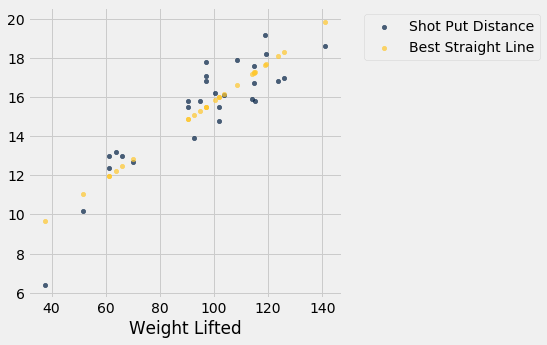

In [12]:
fitted = fit(shotput, 'Weight Lifted', 'Shot Put Distance')
shotput.with_column('Best Straight Line', fitted).scatter('Weight Lifted')

### Nonlinear Regression ###
The graph above reinforces our earlier observation that the scatter plot is a bit curved. So it is better to fit a curve than a straight line. The [study](http://digitalcommons.wku.edu/ijes/vol6/iss2/10/) postulated a quadratic relation between the weight lifted and the shot put distance. So let's use quadratic functions as our predictors and see if we can find the best one. 

We have to find the best quadratic function among all quadratic functions, instead of the best straight line among all straight lines. The method of least squares allows us to do this.

The mathematics of this minimization is complicated and not easy to see just by examining the scatter plot. But numerical minimization is just as easy as it was with linear predictors! We can get the best quadratic predictor by once again using `minimize`. Let's see how this works.

Recall that a quadratic function has the form

$$
f(x) ~=~ ax^2 + bx + c
$$
for constants $a$, $b$, and $c$.

To find the best quadratic function to predict distance based on weight lifted, using the criterion of least squares, we will first write a function that takes the three constants as its arguments, calculates the fitted values by using the quadratic function above, and then returns the mean squared error. 

The function is called `shotput_quadratic_mse`. Notice that the definition is analogous to that of `lw_mse`, except that the fitted values are based on a quadratic function instead of linear.

In [13]:
def shotput_quadratic_mse(a, b, c):
    x = shotput.column('Weight Lifted')
    y = shotput.column('Shot Put Distance')
    fitted = a*(x**2) + b*x + c
    return np.mean((y - fitted) ** 2)

We can now use `minimize` just as before to find the constants that minimize the mean squared error. 

In [14]:
best = minimize(shotput_quadratic_mse)
best

array([-1.04004839e-03,  2.82708045e-01, -1.53182113e+00])

Our prediction of the shot put distance for an athlete who lifts $x$ kilograms is about
$$
-0.00104x^2 ~+~ 0.2827x - 1.5318
$$
meters. For example, if the athlete can lift 100 kilograms, the predicted distance is 16.33 meters. On the scatter plot, that's near the center of a vertical strip around 100 kilograms.

In [15]:
(-0.00104)*(100**2) + 0.2827*100 - 1.5318

16.3382

Here are the predictions for all the values of `Weight Lifted`. You can see that they go through the center of the scatter plot, to a rough approximation.

In [16]:
x = shotput.column(0)
shotput_fit = best.item(0)*(x**2) + best.item(1)*x + best.item(2)

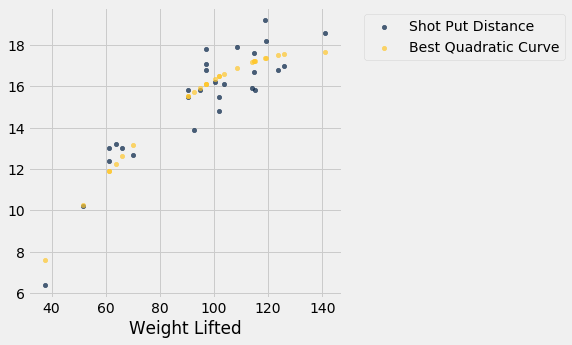

In [17]:
shotput.with_column('Best Quadratic Curve', shotput_fit).scatter(0)